# Checking on the data quality 


In [225]:
import numpy as np
import pickle
import mysql.connector
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import os
from matplotlib.offsetbox import AnchoredText
from scipy.stats import chisquare

### Retrieving and cleaning the data

In [226]:
# this is how we connect and put the mql command

def query(command):
    conn = mysql.connector.connect(user='xxxx',password='xxxxx',host='xxxx',database='xxxx',port='xxxx')
    cursor = conn.cursor()    
    result = pd.read_sql_query(command, conn)
    conn.close()
    return result

In [227]:
cmd = '''
SELECT
   fileid,
   fCurrentsMedMean,
   fNumThreshold500,
   fNumThreshold750,
   fNumThreshold1000,
   fEffectiveOn,
   fRunStart,
   fRunStop,
   fZenithDistanceMean
FROM
    RunInfo
'''

data = query(cmd)

In [228]:
data.shape

(369290, 9)

In [229]:
df = data[(data['fRunStart'] > pd.Timestamp('2016-02-18')) & (data['fRunStart'] < pd.Timestamp('2016-08-31'))]

In [230]:
df

,fileid,fCurrentsMedMean,fNumThreshold500,fNumThreshold750,fNumThreshold1000,fEffectiveOn,fRunStart,fRunStop,fZenithDistanceMean
176531,160217092,NaN,2000.0,1213.0,812.0,NaN,2016-02-18 00:00:07,2016-02-18 00:05:07,30.77
176532,160217093,NaN,NaN,NaN,NaN,0.9835,2016-02-18 00:05:33,2016-02-18 00:06:13,31.32
176533,160217094,-5.1,NaN,NaN,NaN,0.9883,2016-02-18 00:06:15,2016-02-18 00:06:55,31.19
176534,160217095,-5.1,NaN,NaN,NaN,0.9017,2016-02-18 00:06:56,2016-02-18 00:07:01,31.11
176535,160217096,-5.1,NaN,NaN,NaN,0.9014,2016-02-18 00:07:02,2016-02-18 00:07:07,31.09
...,...,...,...,...,...,...,...,...,...
203339,160830081,4.8,NaN,NaN,NaN,0.8663,2016-08-30 23:42:26,2016-08-30 23:42:31,37.40
203340,160830082,4.7,1760.0,1015.0,705.0,0.9567,2016-08-30 23:42:34,2016-08-30 23:47:34,37.52
203341,160830083,4.7,1843.0,1083.0,729.0,0.9563,2016-08-30 23:47:39,2016-08-30 23:52:39,37.76
203342,160830084,4.7,1737.0,985.0,662.0,0.9572,2016-08-30 23:52:43,2016-08-30 23:57:43,38.01


In [231]:
df = df.dropna()
df = df[df['fEffectiveOn'] != 0]

In [232]:
df

,fileid,fCurrentsMedMean,fNumThreshold500,fNumThreshold750,fNumThreshold1000,fEffectiveOn,fRunStart,fRunStop,fZenithDistanceMean
176537,160217098,45.1,2027.0,1216.0,841.0,0.9619,2016-02-18 00:07:44,2016-02-18 00:12:44,30.47
176538,160217099,44.3,2053.0,1178.0,814.0,0.9636,2016-02-18 00:12:49,2016-02-18 00:17:49,29.48
176539,160217100,43.9,2056.0,1185.0,801.0,0.9574,2016-02-18 00:17:53,2016-02-18 00:22:53,28.49
176540,160217101,43.2,2117.0,1243.0,848.0,0.9733,2016-02-18 00:22:58,2016-02-18 00:27:58,27.51
176542,160217103,42.7,2023.0,1194.0,814.0,0.9730,2016-02-18 00:28:28,2016-02-18 00:33:28,25.27
...,...,...,...,...,...,...,...,...,...
203338,160830080,4.6,1804.0,1029.0,706.0,0.9564,2016-08-30 23:37:08,2016-08-30 23:42:08,38.48
203340,160830082,4.7,1760.0,1015.0,705.0,0.9567,2016-08-30 23:42:34,2016-08-30 23:47:34,37.52
203341,160830083,4.7,1843.0,1083.0,729.0,0.9563,2016-08-30 23:47:39,2016-08-30 23:52:39,37.76
203342,160830084,4.7,1737.0,985.0,662.0,0.9572,2016-08-30 23:52:43,2016-08-30 23:57:43,38.01


In [233]:
trigger_threshold = 'fNumThreshold750'



### To find the optimal trigger threshold, perform a linear regression and assess its goodness

In [234]:
timedelta = ((df.fRunStop - df.fRunStart) / df.fEffectiveOn)
eff_on_time = timedelta.dt.total_seconds()

In [235]:
x = df.fCurrentsMedMean

# Change the dataset to test data with different thresholds

y = df[trigger_threshold] / eff_on_time 


In [236]:
y.shape

(17752,)

In [237]:
def test_chisquare(x, y):
    '''
    calculating chi-squared from the given data 
    while testing the goodness of a linear fit. 
    '''
    
    # calculate expected values
    predicted_y = np.poly1d(np.polyfit(x, y, 1))(x)
    
    sigma = y.var()
    
    chi_squared = ((y - predicted_y)**2/ sigma).sum()
    return chi_squared


In [238]:
chi2_per_ndf = test_chisquare(x,y)/(len(y) - 2)

In [239]:
chi2_per_ndf

0.9916551886878198

In [240]:
# get p0 and p_1, the highest degree of the polynomial fit is indicated first!
linear_fit = np.poly1d(np.polyfit(x, y, 1))
p1 = linear_fit[0]
p0 = linear_fit[1]

In [241]:
f_exp = linear_fit(x)

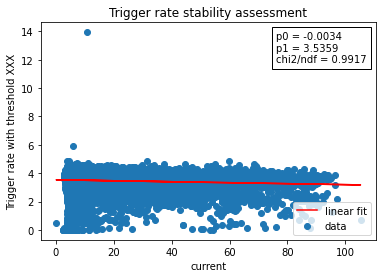

In [242]:
plt.scatter(x, y, label = 'data')
plt.plot(x, f_exp, color='red', label = 'linear fit')
plt.xlabel(r'current')
plt.ylabel('Trigger rate with threshold XXX')

plt.title(r'Trigger rate stability assessment')
plt.legend()
plt.legend(loc='lower right')


ax = plt.gca()
at0 = AnchoredText(
                f"p0 = {round(p0,4)}\n"
                f"p1 = {round(p1,4)}\n"
                f"chi2/ndf = {round(chi2_per_ndf,4)}"
                , loc='upper right')

# zooming in
#ax.set_ylim(-0.25, 6)

ax.add_artist(at0)

### Plot trigger rate vs Zenith angle

In [243]:
def bin_triggerrate_per_zenith(df, bin_size, tr):
    ''' 
    Trigger rates are returned with binning per Zenith angle. 
    '''
  
    bins = np.rint((df.fZenithDistanceMean.max() - df.fZenithDistanceMean.min()) / bin_size)
    n_bins = int(bins)
    z_bins = np.linspace(df.fZenithDistanceMean.min(), df.fZenithDistanceMean.max(), n_bins) 

    x = [(z_bins[i] + z_bins[i+1])/2 for i in range(len(z_bins)-1)]
    y = []
    
    df['trigger_rate_norm'] = df[tr] / eff_on_time

    for i in range(len(z_bins) -1):
        z_max = z_bins[i + 1]
        z_min = z_bins[i]
        y.append(y.append(df[(df['fZenithDistanceMean'] <= z_max) & (df['fZenithDistanceMean'] > z_min)]['trigger_rate_norm'].mean()))
    return x, y

In [244]:
zen, triggerrate = bin_triggerrate_per_zenith(df, 5, trigger_threshold)

In [245]:
zen = np.array(zen)
triggerrate = [x for x in triggerrate if x is not None]
triggerrate = np.array(triggerrate)

In [246]:
zen_cut = 32

Text(0, 0.5, 'Trigger rate / on time')

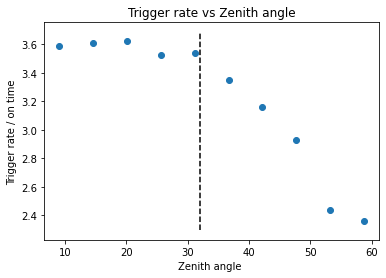

In [247]:
plt.scatter(zen, triggerrate)
plt.vlines(x=zen_cut, ymin=plt.ylim()[0], ymax=plt.ylim()[1], ls='--', color='black')

plt.title(r'Trigger rate vs Zenith angle')
plt.xlabel('Zenith angle ')
plt.ylabel('Trigger rate / on time')